<a href="https://colab.research.google.com/github/Melisa7L/PPS/blob/main/Redes_neuronales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Las pruebas para realizar todos los comandos y la red neuronal se hicieron con un excel reducido de las noticias (por el tema de la ram y el colab que tienen un tamaño limite de datos para usar). este excel reducido cuenta con noticias de cada categoria para poder probar .

Librerias

In [1]:
pip install pandas spacy scikit-learn gensim matplotlib

In [2]:
pip install nltk

In [3]:
pip install spacy

In [4]:
!python -m spacy download es_core_news_sm

2023-11-28 14:28:36.657034: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-28 14:28:36.657128: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-28 14:28:36.657181: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-28 14:28:36.683411: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-28 14:28:41.019634: W tensorflow/compiler/

In [5]:
pip install scikit-learn

In [6]:
pip install scipy

In [7]:
pip install tensorflow

Se extraen las palabras influyentes directamente de los pesos de la capa de entrada de la red neuronal, que se conecta a la representación TF-IDF de las palabras. No está directamente relacionado con la parte de palabras frecuentes o el vectorizador TF-IDF utilizado en el código anterior para K-Means.

En este enfoque, las palabras influyentes se derivan de los pesos que la red neuronal ha ajustado durante el entrenamiento. Cada peso está asociado a una palabra específica del vocabulario utilizado por el vectorizador TF-IDF.


**CODIGO COMPLETO DONDE SE ESTA IMPLEMENTANDO LA RED NEURONAL,LA MATIZ DE CORRELACION DE CADA CATEGORIA Y LOS GRAFICOS QUE SE OBTUVIERON EN BASE A ESTOS DATOS(HISTOGRAMA,BOXPLOT)**

In [12]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import spacy
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

df = pd.read_excel('Data_para_Red.xlsx')

# Lista de categorías
categorias = df['categoria'].unique()

# Crear un diccionario para mapear categorías a números
categoria_a_numero = {cat: num for num, cat in enumerate(categorias)}

# Listas donde se van a guardar los resultados
all_predicted_classes = []
all_conf_matrices = []

# Con el for voy a recorrer cada categoría
for categoria in categorias:
   # Filtrar las filas que pertenecen a la categoría específica
    df_categoria = df[df['categoria'] == categoria]
    #Se analizan todas las categorias con el texto
    text = ' '.join(df_categoria['texto_noticia'].astype(str))

    # Normalización del texto
    text = re.sub(r'[^\w\s]', '', text)
    text = text.lower()
    nlp = spacy.load('es_core_news_sm')
    nlp.max_length = len(text) + 100000
    doc = nlp(text)

    # Filtrar palabras relevantes(se tienen en cuenta las palabras que son adjetivos,sustantivos y verbos que se relacionan con las categorias)
    filtered_words = [token.lemma_ for token in doc if
                      token.pos_ in ('NOUN', 'ADJ', 'VERB') and
                      token.lemma_.lower() not in nlp.Defaults.stop_words and
                      token.lemma_.isalpha() and
                      len(token.lemma_) > 2]

    filtered_text = ' '.join(filtered_words)

    # Contar la frecuencia de las palabras utilizando un diccionario
    word_freq = Counter(filtered_words)

    # Guardar las palabras más frecuentes en un archivo de texto con codificación UTF-8 para que me tome los acentos y las palabras correctamente.
    with open(f'palabras_mas_frecuentes_{categoria}.txt', 'w', encoding='utf-8') as file:
        for word, freq in word_freq.most_common():
            file.write(f"{word}: {freq}\n")

    # Cargar las palabras más frecuentes desde el archivo de texto, como voy a trabajar con esas palabras abro el txt generado
    palabras_mas_frecuentes = []
    with open(f'palabras_mas_frecuentes_{categoria}.txt', 'r', encoding='utf-8') as file:
        for line in file:
            palabra = line.split(":")[0].strip()
            palabras_mas_frecuentes.append(palabra)

    # Eliminar repetidos de la lista de palabras más frecuentes
    palabras_mas_frecuentes = list(set(palabras_mas_frecuentes))

    # Vectorización con reducción de dimensionalidad mediante umbral de frecuencia (TF-IDF)
    #(TF-IDF es un cálculo estadístico adoptado por el algoritmo de Google para medir qué términos
    #son más relevantes para un asunto, analizando la frecuencia con que aparecen en una página,
    #en comparación con su frecuencia en un conjunto más grande de páginas.)
    vectorizer_tfidf = TfidfVectorizer(vocabulary=palabras_mas_frecuentes)
    X_tfidf = vectorizer_tfidf.fit_transform(df_categoria['texto_noticia'])
    palabras_tfidf = vectorizer_tfidf.get_feature_names_out()

    # Creación del modelo de red neuronal
    model = Sequential()
    model.add(Dense(128, input_shape=(len(palabras_mas_frecuentes),), activation='relu'))
    model.add(Dense(len(categorias), activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Entrenamiento del modelo
    labels = df_categoria['categoria'].apply(lambda x: categoria_a_numero[x])
    model.fit(X_tfidf.toarray(), labels, epochs=10, batch_size=32, validation_split=0.2)

    # Obtener los pesos de la capa de entrada
    weights_input_layer = model.layers[0].get_weights()[0]

    # Guardar las palabras más influyentes en cada neurona en un archivo de texto
    with open(f'palabras_influyentes_{categoria}.txt', 'w', encoding='utf-8') as result_file:
        for neurona_num in range(5):  # Estoy trabajando con 5 neuronas por eleccion
            # Obtener los pesos asociados a cada palabra en la neurona
            pesos_neurona = weights_input_layer[:, neurona_num]

            # Ordenar los índices por valor absoluto de los pesos (en orden descendente)
            indices_ordenados = sorted(range(len(pesos_neurona)), key=lambda i: abs(pesos_neurona[i]), reverse=True)

            # Obtener las palabras más influyentes
            palabras_influyentes = [palabras_tfidf[indice] for indice in indices_ordenados]
            #Lo que se va a mostrar en consola que seria el n° de neurona y la categoria de noticia de la cual se esta mostrando
            result_file.write(f"Neurona {neurona_num} - Categoría: {categoria_a_numero[categoria]}\n")
            result_file.write(', '.join(palabras_influyentes) + '\n\n')
            print(f"Neurona {neurona_num} - Categoría: {categoria}")
            print(palabras_influyentes)

    # Dividir el conjunto de datos en entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X_tfidf.toarray(), labels, test_size=0.2, random_state=42)

    # Crear el modelo final
    final_model = Sequential()
    final_model.add(Dense(128, input_shape=(X_train.shape[1],), activation='relu'))
    final_model.add(Dense(len(categorias), activation='softmax'))
    final_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Entrenar el modelo final con todo el conjunto de datos
    final_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

    # Evaluar el modelo final en el conjunto de prueba
    final_model.evaluate(X_test, y_test)

    # Obtener probabilidades predichas
    probabilities = final_model.predict(X_test)

    # Obtener la clase con la probabilidad más alta para cada muestra
    predicted_classes = tf.argmax(probabilities, axis=1)

    # Calcular matriz de confusión
    conf_matrix = confusion_matrix(y_test, predicted_classes)

    # Agregar resultados a las listas
    all_predicted_classes.append(predicted_classes)
    all_conf_matrices.append(conf_matrix)

#Matriz de Correlación por cada Categoría

# Obtener los pesos de la capa de entrada
weights_input_layer = model.layers[0].get_weights()[0]

# Transponer la matriz de pesos
weights_input_layer_T = np.transpose(weights_input_layer)

# Crear un DataFrame para facilitar el filtrado
df_corr = pd.DataFrame(weights_input_layer_T, columns=palabras_tfidf)

# Inicializar un diccionario para guardar las matrices de correlación por categoría
corr_matrices_por_categoria = {}

# Iterar sobre cada categoría
for categoria in categorias:
    # Filtrar palabras por categoría
    df_categoria = df_corr[df['categoria'] == categoria]

    # Seleccionar las palabras más relevantes de la categoría
    palabras_relevantes = df_categoria.mean(axis=0).sort_values(ascending=False).index[:6].tolist()

    # Filtrar el DataFrame original para incluir solo las palabras relevantes de la categoría
    df_corr_relevantes = df_corr[palabras_relevantes]

    # Calcular la matriz de correlación
    corr_matrix = df_corr_relevantes.corr()

    # Almacenar la matriz de correlación en el diccionario
    corr_matrices_por_categoria[categoria] = corr_matrix

# Obtener los pesos de la capa de entrada
weights_input_layer = model.layers[0].get_weights()[0]

# Transponer la matriz de pesos
weights_input_layer_T = np.transpose(weights_input_layer)

# Crear un DataFrame para facilitar el filtrado
df_corr = pd.DataFrame(weights_input_layer_T, columns=palabras_tfidf)

# Inicializar un diccionario para almacenar las matrices de correlación por categoría
corr_matrices_por_categoria = {}

# Iterar sobre cada categoría
for categoria in categorias:
    # Filtrar palabras por categoría
    df_categoria = df_corr[df['categoria'] == categoria]

    # Seleccionar seis palabras más relevantes de la categoría
    palabras_relevantes = df_categoria.mean(axis=0).sort_values(ascending=False).index[:6].tolist()

    # Filtrar el DataFrame original para incluir solo las palabras relevantes de la categoría
    df_corr_relevantes = df_corr[palabras_relevantes]

    # Calcular la matriz de correlación
    corr_matrix = df_corr_relevantes.corr()

    # Almacenar la matriz de correlación en el diccionario
    corr_matrices_por_categoria[categoria] = corr_matrix



Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 2.2846 - accuracy: 0.1875 - val_loss: 2.2464 - val_accuracy: 0.6000
Epoch 2/10
1/1 [==============================] - 0s 79ms/step - loss: 2.2327 - accuracy: 0.5625 - val_loss: 2.2177 - val_accuracy: 1.0000
Epoch 3/10
1/1 [==============================] - 0s 101ms/step - loss: 2.1826 - accuracy: 1.0000 - val_loss: 2.1888 - val_accuracy: 1.0000
Epoch 4/10
1/1 [==============================] - 0s 131ms/step - loss: 2.1338 - accuracy: 1.0000 - val_loss: 2.1592 - val_accuracy: 1.0000
Epoch 5/10
1/1 [==============================] - 0s 97ms/step - loss: 2.0859 - accuracy: 1.0000 - val_loss: 2.1285 - val_accuracy: 1.0000
Epoch 6/10
1/1 [==============================] - 0s 79ms/step - loss: 2.0379 - accuracy: 1.0000 - val_loss: 2.0967 - val_accuracy: 1.0000
Epoch 7/10
1/1 [==============================] - 0s 82ms/step - loss: 1.9890 - accuracy: 1.0000 - val_loss: 2.0639 - val_accuracy: 1.0000
Epoch 8/10
1/1 [===========

1/1 [==============================] - 0s 98ms/step
Epoch 1/10
1/1 [==============================] - 1s 735ms/step - loss: 2.3164 - accuracy: 0.0000e+00 - val_loss: 2.2691 - val_accuracy: 0.3750
Epoch 2/10
1/1 [==============================] - 0s 85ms/step - loss: 2.2545 - accuracy: 0.6875 - val_loss: 2.2331 - val_accuracy: 0.8750
Epoch 3/10
1/1 [==============================] - 0s 77ms/step - loss: 2.1966 - accuracy: 0.9688 - val_loss: 2.1971 - val_accuracy: 1.0000
Epoch 4/10
1/1 [==============================] - 0s 84ms/step - loss: 2.1419 - accuracy: 1.0000 - val_loss: 2.1607 - val_accuracy: 1.0000
Epoch 5/10
1/1 [==============================] - 0s 78ms/step - loss: 2.0883 - accuracy: 1.0000 - val_loss: 2.1235 - val_accuracy: 1.0000
Epoch 6/10
1/1 [==============================] - 0s 60ms/step - loss: 2.0338 - accuracy: 1.0000 - val_loss: 2.0844 - val_accuracy: 1.0000
Epoch 7/10
1/1 [==============================] - 0s 56ms/step - loss: 1.9772 - accuracy: 1.0000 - val_loss: 

1/1 [==============================] - 0s 120ms/step
Epoch 1/10
1/1 [==============================] - 1s 735ms/step - loss: 2.3003 - accuracy: 0.1250 - val_loss: 2.2505 - val_accuracy: 0.6250
Epoch 2/10
1/1 [==============================] - 0s 81ms/step - loss: 2.2468 - accuracy: 0.6562 - val_loss: 2.2064 - val_accuracy: 0.8750
Epoch 3/10
1/1 [==============================] - 0s 86ms/step - loss: 2.1955 - accuracy: 1.0000 - val_loss: 2.1632 - val_accuracy: 1.0000
Epoch 4/10
1/1 [==============================] - 0s 60ms/step - loss: 2.1456 - accuracy: 1.0000 - val_loss: 2.1187 - val_accuracy: 1.0000
Epoch 5/10
1/1 [==============================] - 0s 79ms/step - loss: 2.0963 - accuracy: 1.0000 - val_loss: 2.0731 - val_accuracy: 1.0000
Epoch 6/10
1/1 [==============================] - 0s 73ms/step - loss: 2.0465 - accuracy: 1.0000 - val_loss: 2.0263 - val_accuracy: 1.0000
Epoch 7/10
1/1 [==============================] - 0s 87ms/step - loss: 1.9950 - accuracy: 1.0000 - val_loss: 1.9

<ipython-input-12-8cf512087388>:152: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_categoria = df_corr[df['categoria'] == categoria]
<ipython-input-12-8cf512087388>:152: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_categoria = df_corr[df['categoria'] == categoria]
<ipython-input-12-8cf512087388>:152: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_categoria = df_corr[df['categoria'] == categoria]
<ipython-input-12-8cf512087388>:152: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_categoria = df_corr[df['categoria'] == categoria]
<ipython-input-12-8cf512087388>:152: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_categoria = df_corr[df['categoria'] == categoria]
<ipython-input-12-8cf512087388>:152: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_categoria = df_corr[df['categoria'] == cat

**MATRIZ DE CORRELACION**

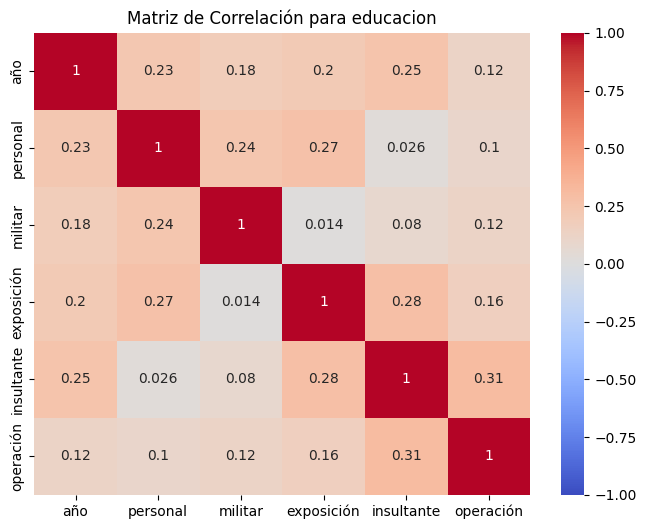

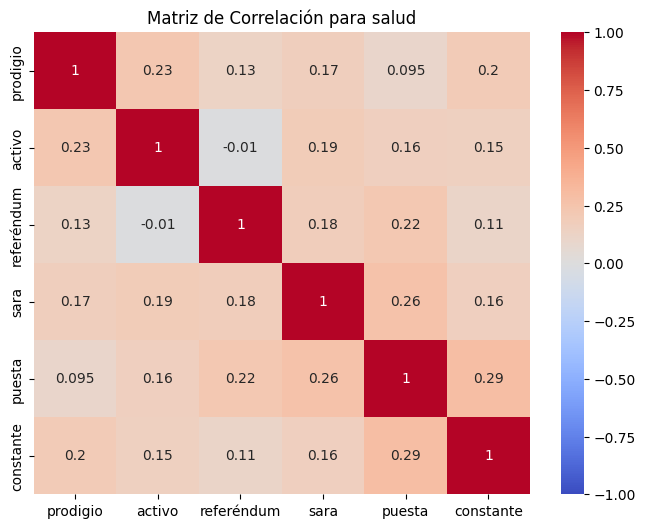

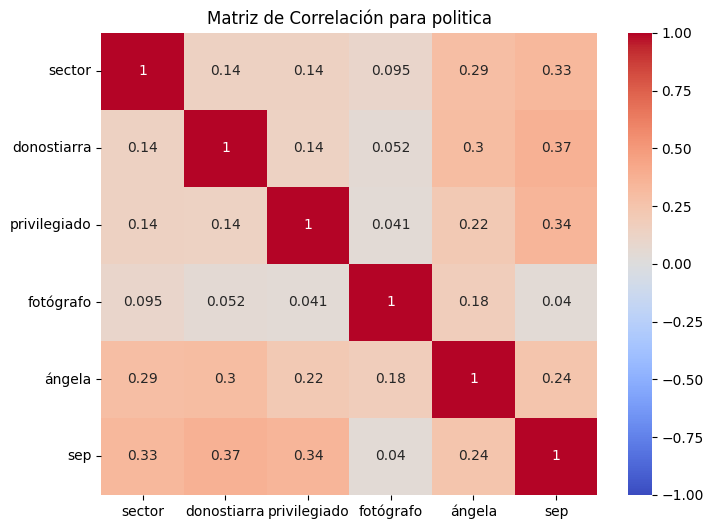

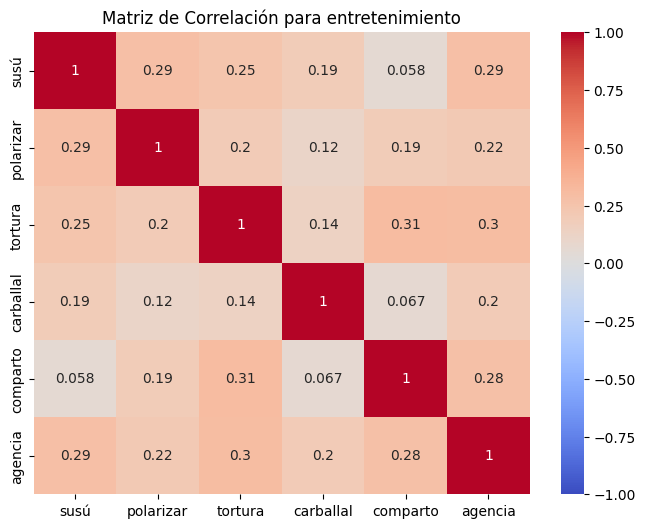

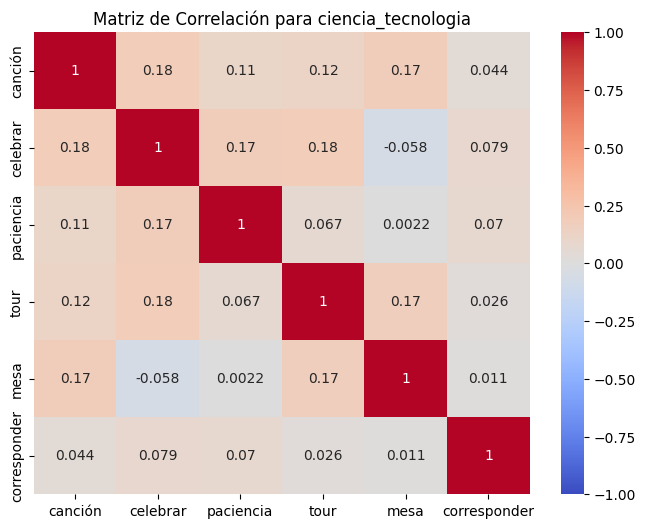

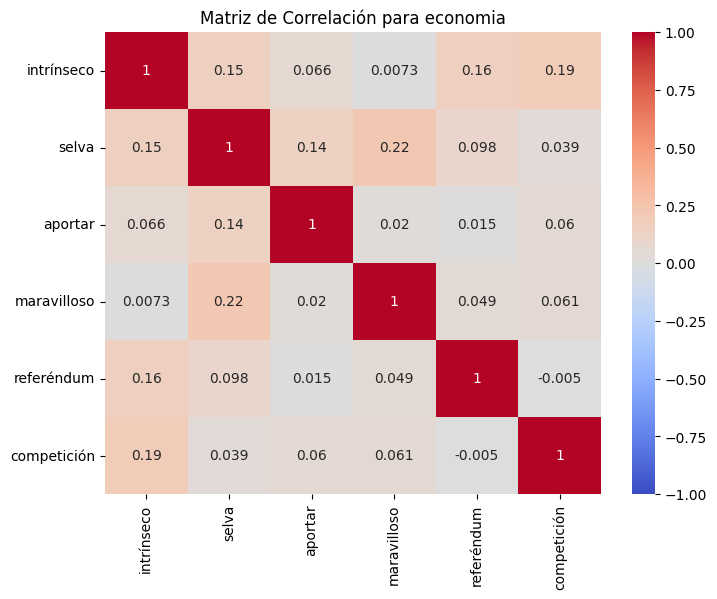

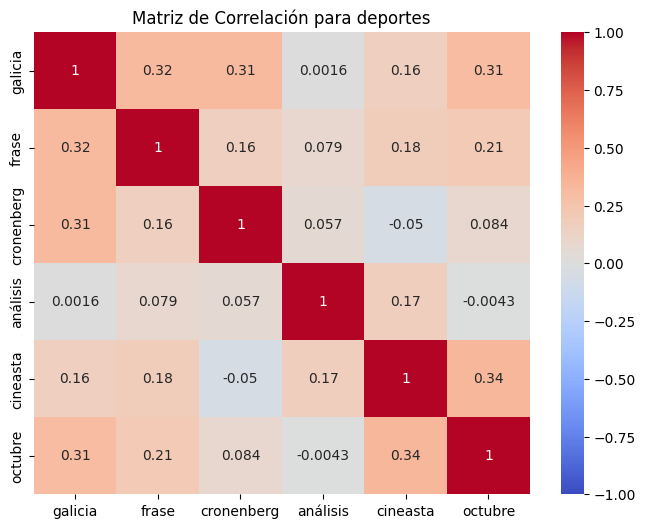

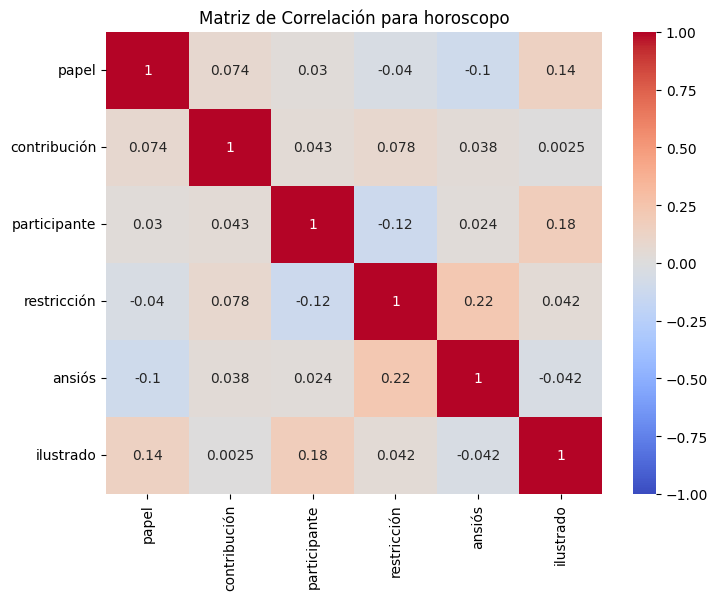

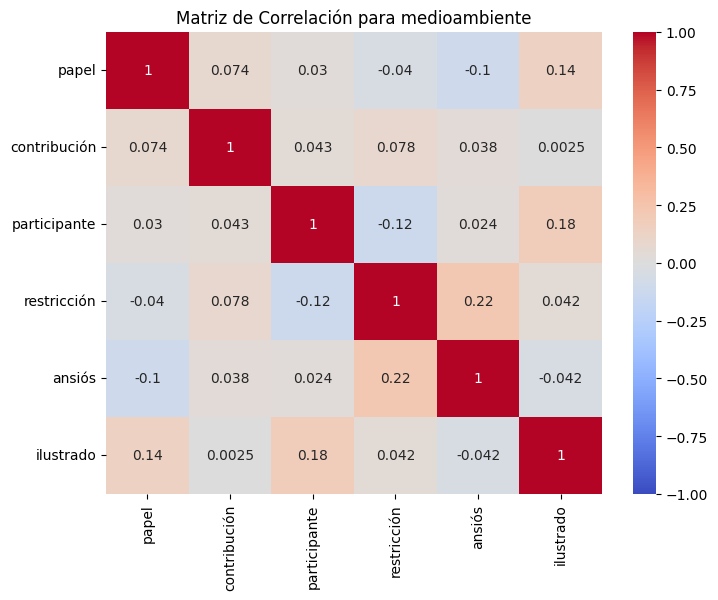

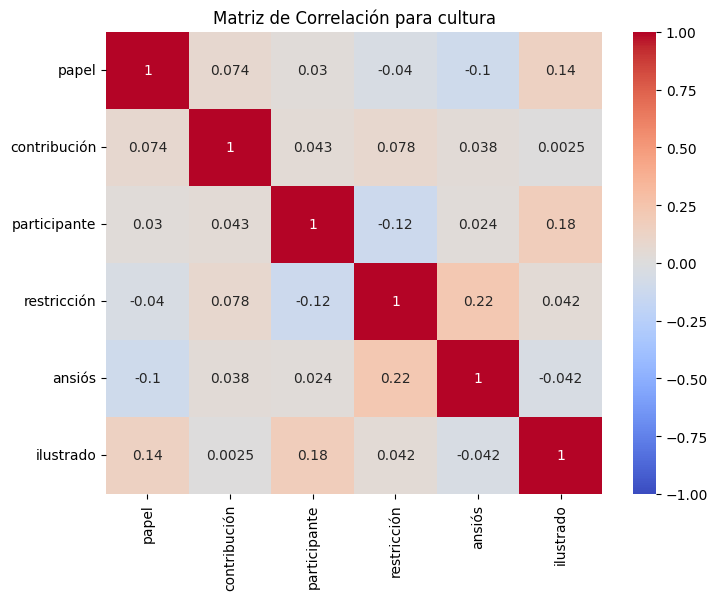

In [13]:
# Visualizar las matrices de correlación por categoría
for categoria, corr_matrix in corr_matrices_por_categoria.items():
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1, annot=True)
    plt.title(f'Matriz de Correlación para {categoria}')
    plt.show()


**HISTOGRAMA**

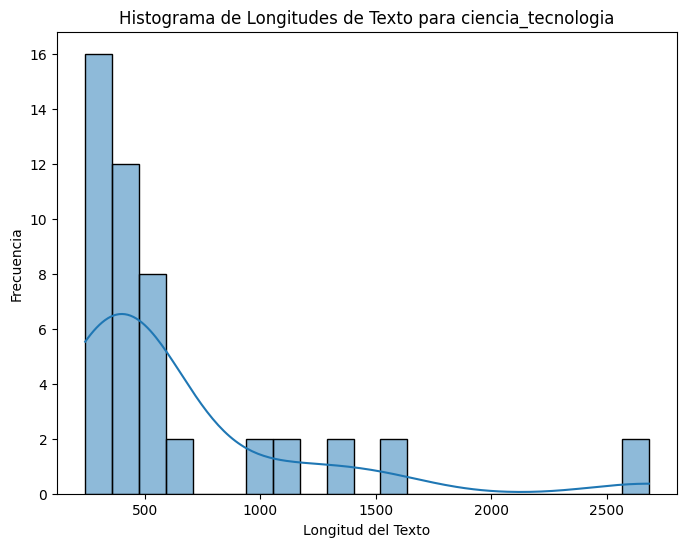

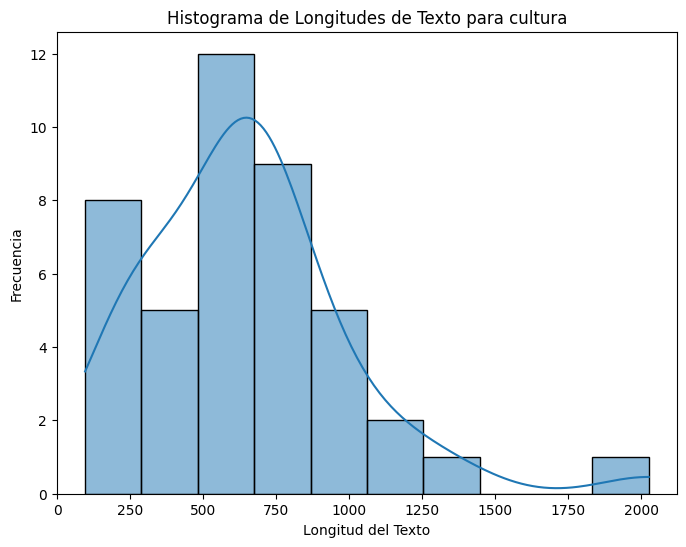

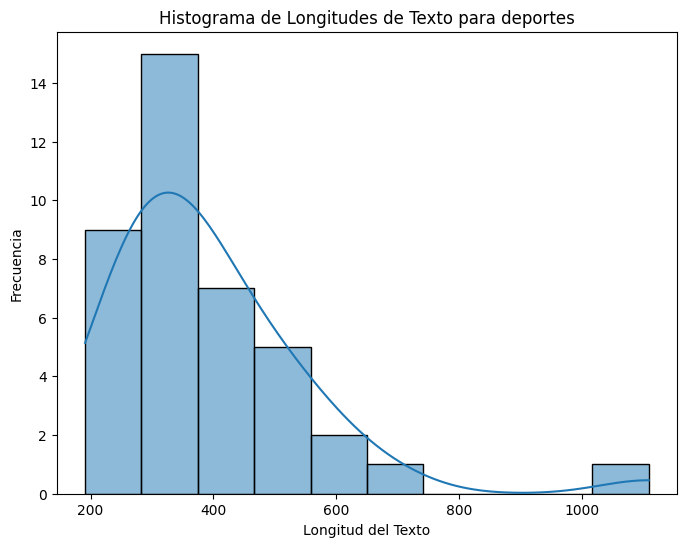

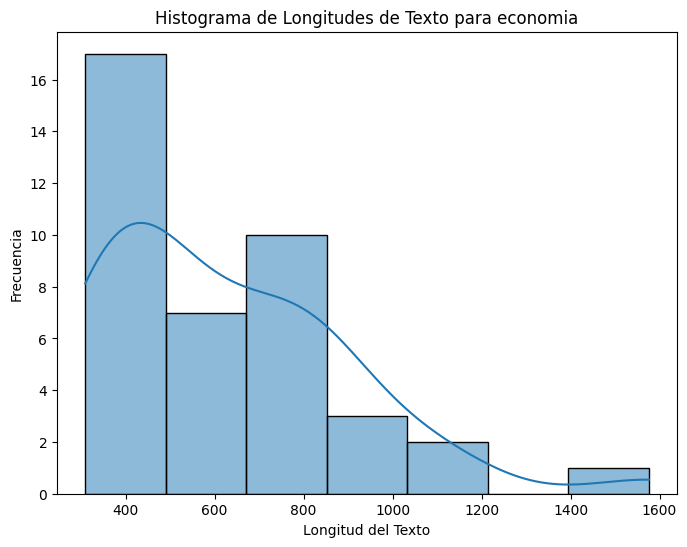

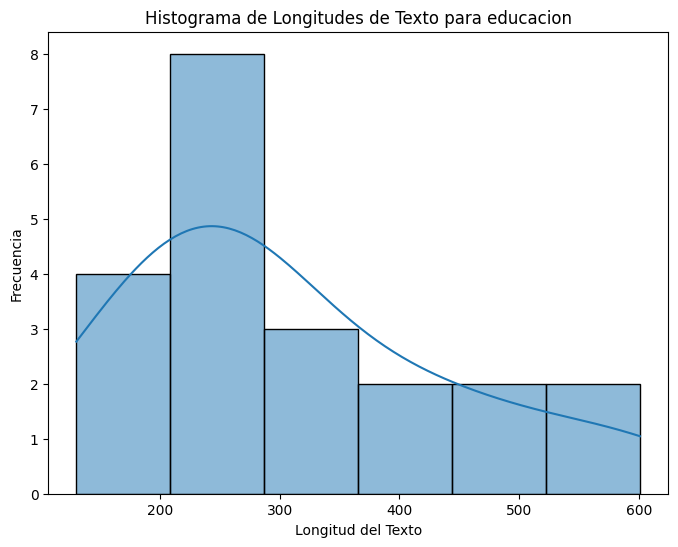

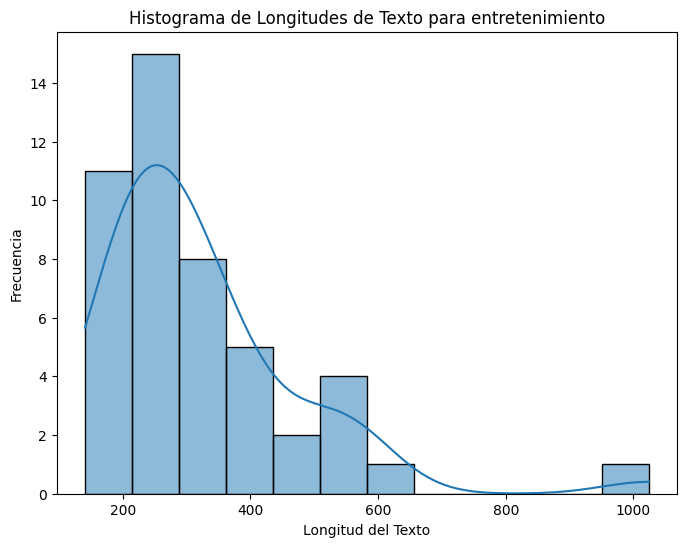

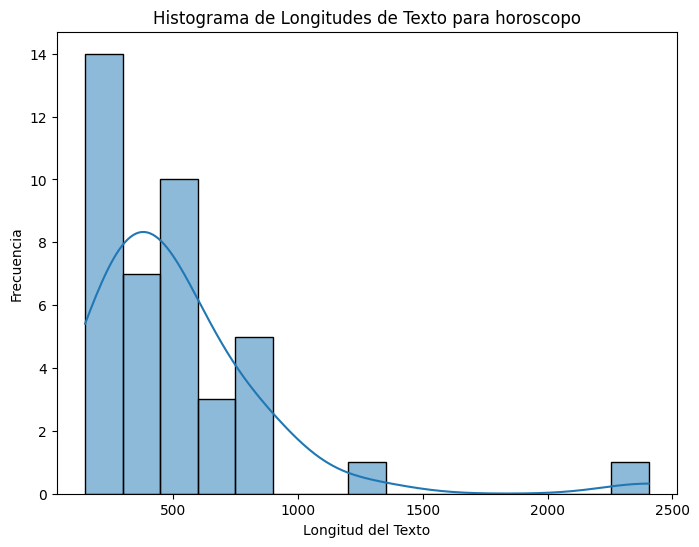

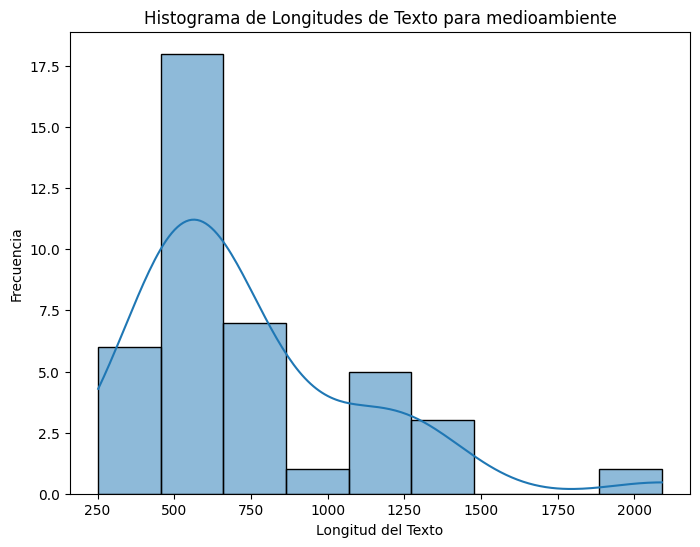

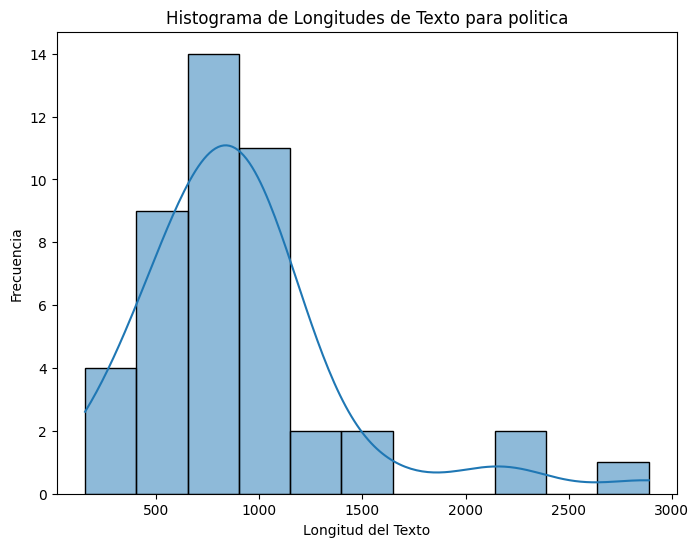

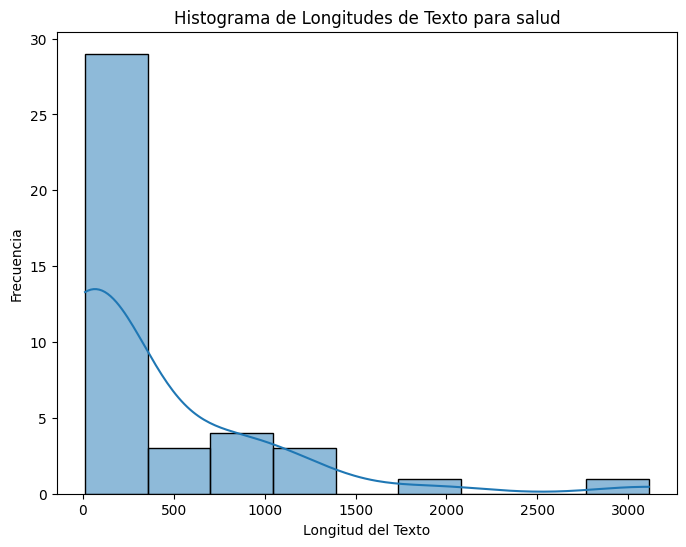

In [14]:
# Histograma
for categoria, df_categoria in df.groupby('categoria'):
    plt.figure(figsize=(8, 6))
    sns.histplot(df_categoria['texto_noticia'].apply(lambda x: len(x.split())), kde=True)
    plt.title(f'Histograma de Longitudes de Texto para {categoria}')
    plt.xlabel('Longitud del Texto')
    plt.ylabel('Frecuencia')
    plt.show()

***BOXPLOT***

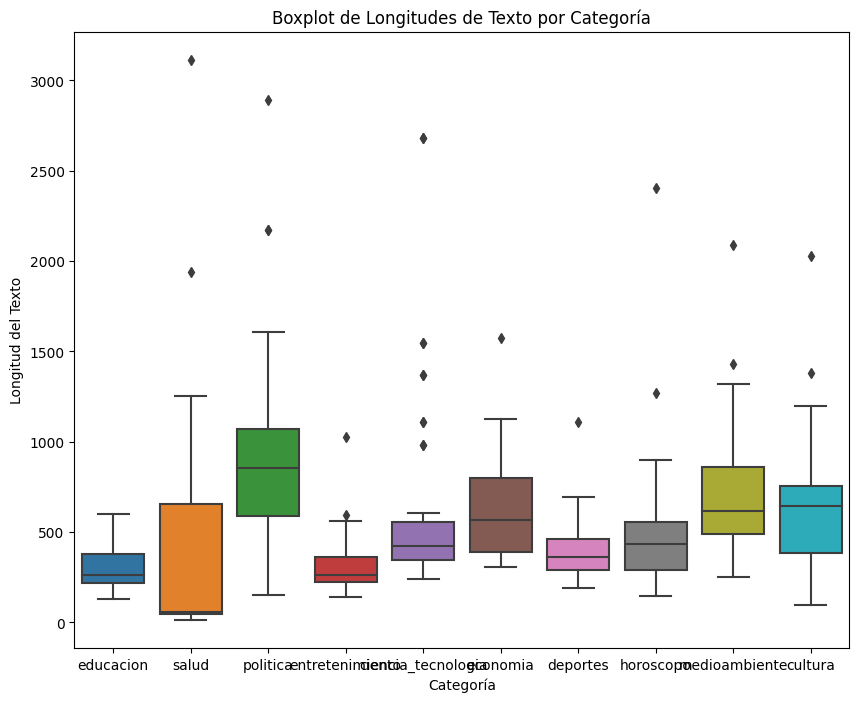

In [15]:
# Boxplot
plt.figure(figsize=(10, 8))
sns.boxplot(x='categoria', y=df['texto_noticia'].apply(lambda x: len(x.split())), data=df)
plt.title('Boxplot de Longitudes de Texto por Categoría')
plt.xlabel('Categoría')
plt.ylabel('Longitud del Texto')
plt.show()


**En base al codigo , se puede implementar unos metodos para ver como esta funcionando la red neuronal**

**Climate Charts: en este caso es para la longitud_texto en mi dataframe**

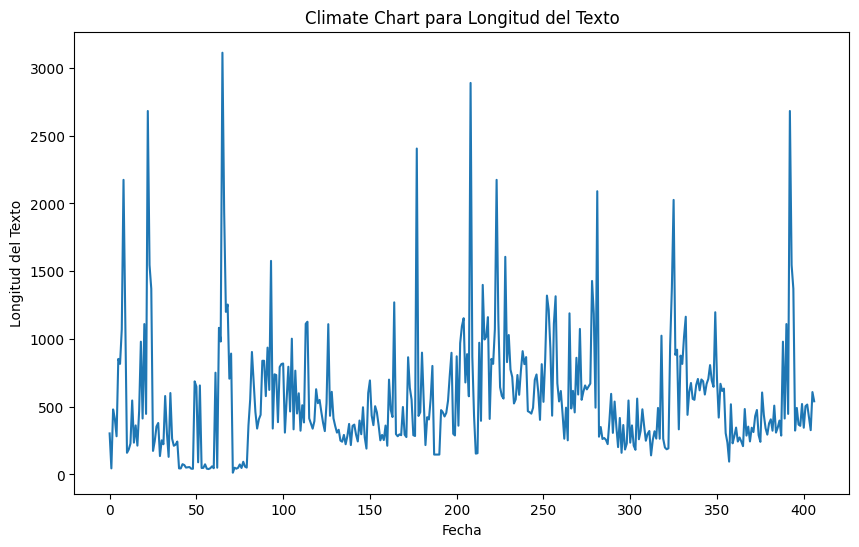

In [16]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
sns.lineplot(x=df.index, y=df['texto_noticia'].apply(lambda x: len(x.split())))
plt.title('Climate Chart para Longitud del Texto')
plt.xlabel('Fecha')
plt.ylabel('Longitud del Texto')
plt.show()


In [20]:
pip install seaborn

**MAPA DE DECISIONES**

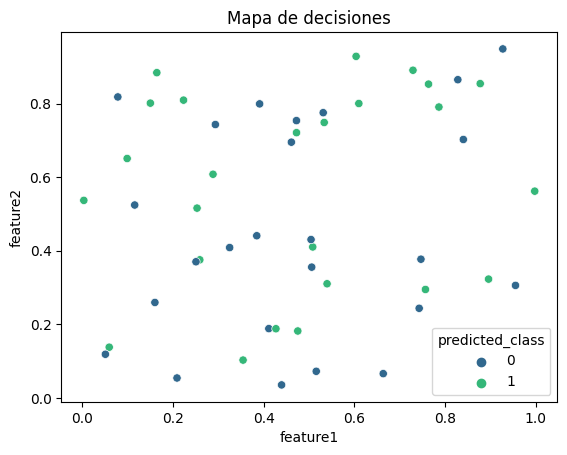

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Datos de ejemplo
X_test = np.random.rand(50, 2)
predicted_classes = np.random.randint(0, 2, 50)

# Crear un DataFrame con los datos
data = {'feature1': X_test[:, 0], 'feature2': X_test[:, 1], 'predicted_class': predicted_classes}
df = pd.DataFrame(data)

# Visualización con Seaborn
sns.scatterplot(x='feature1', y='feature2', hue='predicted_class', data=df, palette='viridis')
plt.title('Mapa de decisiones')
plt.show()
